
Copyright 2019-2022 Universidad Complutense de Madrid

This file software has been employed to reduce infrared raw data from the CIRCE camera at GTC (see [Cabello et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...659A.116C/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), 
         Nicolás Cardiel (cardiel@ucm.es)
         Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+
License-Filename: LICENSE.txt


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math as m

from astropy.io import ascii
from astropy.io import fits
from astropy.stats import SigmaClip

from matplotlib import rcParams
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_pdf import PdfPages

from photutils import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground

from scipy import stats 
import sep


## <span style="color:red"> FLUX CALIBRATION OF THE NB1257/CIRCE IMAGE (I) </span>

### Compute the zero-point (ZP) needed to transform units of ADU/s to AB magnitudes

First, we load the data:

In [2]:
with fits.open('CIRCE_image.fits', mode='readonly') as hdulist:
    image_CIRCE  = hdulist[0].data
    
with fits.open('HST_image_conv.fits', mode='readonly') as hdulist:
    image_HST  = hdulist[0].data

Then, we performa a 2D background subtraction using the SEP code:

In [3]:
image_CIRCE = image_CIRCE.byteswap().newbyteorder()

# measure a spatially varying background on the image 

bkg = sep.Background(image_CIRCE)

# evaluate background as 2-d array, same size as original image 
bkg_image = bkg.back()

# evaluate the background noise as 2-d array, same size as original image 
bkg_rms = bkg.rms()

# subtract the background

data_sub_CIRCE = (image_CIRCE - bkg)


We extract the position (X,Y) of the 4 brightest stars in the NB1257 image:


Detected objects:  4


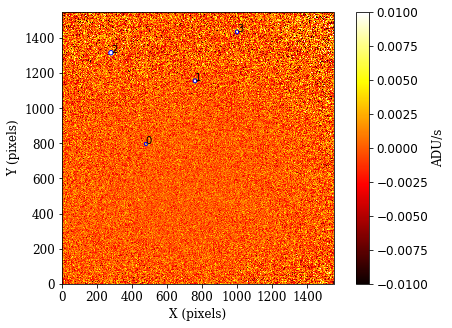

In [4]:
objects, seg = sep.extract(data_sub_CIRCE, 3.5, err=bkg_rms, minarea=100, filter_type='matched', segmentation_map=True)


# how many objects were detected

print('Detected objects: ', len(objects))

###################################

# plot background-subtracted CIRCE image with the detected objects

fig, ax = plt.subplots(figsize=(8,5))
cmap = ax.imshow(data_sub_CIRCE, interpolation='nearest', cmap='hot', aspect='equal', origin='lower',vmin=-0.01, vmax=0.01) 
ax.set_xlabel('X (pixels)', fontsize=12,family='serif')
ax.set_ylabel('Y (pixels)', fontsize=12,family='serif')
cb = plt.colorbar(cmap) 
cb.ax.tick_params(labelsize=12)
cb.set_label('ADU/s', fontsize=12,family='serif')
plt.yticks(fontname = 'serif', size=12)
plt.xticks(fontname = 'serif', size=12)
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                         width=6*objects['a'][i],
                         height=6*objects['b'][i],
                         angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')
    ax.add_artist(e)
    plt.text(objects['x'][i], objects['y'][i], i)
plt.show()    

We compute the half-light flux radius of each source, i.e. the radius of a circle containing half the total flux of the object. We also sort the stars from the brightest to the faintest.

In [5]:
radio_test,flags = sep.flux_radius(data_sub_CIRCE, objects['x'], objects['y'],6*objects['a'], 0.5)


radios_half_light1 = radio_test[2] # STAR 1
radios_half_light2 = radio_test[1] # STAR 2
radios_half_light3 = radio_test[3] # STAR 3
radios_half_light4 = radio_test[0] # STAR 4

radios = [radios_half_light1,radios_half_light2,radios_half_light3,radios_half_light4]

print('STAR 1, STAR 2, STAR 3, STAR 4')
print('Half-light radii (px): ', np.round(radios,2))


STAR 1, STAR 2, STAR 3, STAR 4
Half-light radii (px):  [4.22 4.6  4.44 4.43]


We carry out aperture photometry to obtain the flux of each source within the previously computed half-light radii.

In [6]:
positions = [(objects['x'][2], objects['y'][2]),(objects['x'][1], objects['y'][1]),
            (objects['x'][3], objects['y'][3]),(objects['x'][0], objects['y'][0])]

fluxes = []

for i in range(len(radios)):
    
    aperture = CircularAperture(positions[i], r=radios[i])
    annulus_aperture = CircularAnnulus(positions[i], r_in=15, r_out=30)
    
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data_sub_CIRCE, apers)
    
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  
    fluxes.append(np.float(phot_table['aperture_sum_0']))

print('STAR 1, STAR 2, STAR 3, STAR 4')
print('Fluxes (ADU/s): ', np.round(fluxes,2))

STAR 1, STAR 2, STAR 3, STAR 4
Fluxes (ADU/s):  [25.61  2.11  1.05  0.3 ]


Now, we focus on the HST. We carry out the sky subtraction and the source extraction:

In [7]:
image_HST = image_HST.byteswap().newbyteorder()

# measure a spatially varying background on the image 
bkg = sep.Background(image_HST)

# evaluate background as 2-d array, same size as original image 
bkg_image = bkg.back()

# evaluate the background noise as 2-d array, same size as original image 
bkg_rms = bkg.rms()

# subtract the background
data_sub_image_HST = image_HST - bkg


Detected objects:  10


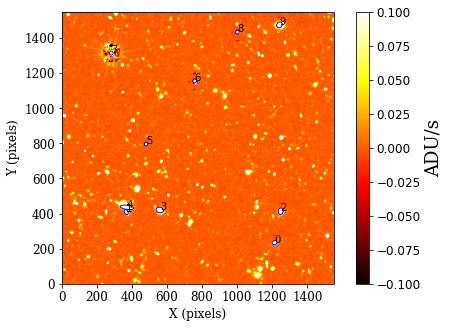

In [8]:
objects, seg = sep.extract(data_sub_image_HST, 200, err=bkg_rms, minarea=300, filter_type='matched', segmentation_map=True)


# how many objects were detected

print('Detected objects: ', len(objects))

###################################



# plot background-subtracted HST image with the detected objects

fig, ax = plt.subplots(figsize=(8,5))
cmap = ax.imshow(data_sub_image_HST, interpolation='nearest', cmap='hot', aspect='equal', origin='lower',vmin=-0.1, vmax=0.1) 
ax.set_xlabel('X (pixels)', fontsize=12,family='serif')
ax.set_ylabel('Y (pixels)', fontsize=12,family='serif')
cb = plt.colorbar(cmap) 
cb.ax.tick_params(labelsize=12)
cb.set_label('ADU/s', fontsize=18,family='serif')
plt.yticks(fontname = 'serif', size=12)
plt.xticks(fontname = 'serif', size=12)
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                         width=6*objects['a'][i],
                         height=6*objects['b'][i],
                         angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')
    ax.add_artist(e)
    plt.text(objects['x'][i], objects['y'][i], i)
plt.show()  

Since we are insterested only in the four brightest stars, we remove the remaining sources:

In [9]:
objects_new = np.delete(objects, (0,1,2,3,4,9))

We carry out circular aperture photometry to obtain the flux of each source within the previously computed half-light radii. In addition, the F125W/HST image is already flux calibrated and therefore we know its zero-point (ZP= 26.25) needed to transform units of ADU/s to AB magnitudes.
We compute then the AB magnitudes:

In [10]:

positions = [(objects_new['x'][2], objects_new['y'][2]),(objects_new['x'][1], objects_new['y'][1]),
            (objects_new['x'][3], objects_new['y'][3]),(objects_new['x'][0], objects_new['y'][0])]


fluxes_HST = []
mag_HST = []

for i in range(len(radios)):
    
    aperture = CircularAperture(positions[i], r=radios[i])
    annulus_aperture = CircularAnnulus(positions[i], r_in=30, r_out=60)

    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data_sub_image_HST, apers)
    
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  
    fluxes_HST.append(np.float(phot_table['aperture_sum_0']))


for i in fluxes_HST:
    mag_HST.append(26.25 - 2.5*np.log10(i))
    
print('STAR 1, STAR 2, STAR 3, STAR 4')
print('Magnitudes (AB): ', np.round(mag_HST,2))


STAR 1, STAR 2, STAR 3, STAR 4
Magnitudes (AB):  [15.57 17.92 18.61 20.19]


Finally, we use the stars present in the image to perform the flux calibration of the NB1257 image. Assuming that the mean color for the brightest stars is zero, we compute the zero-points using the following expression: 


#### ZP = `mag(AB)` $ + \, 2.5 \, log($ `Flux(ADU/s)` )

We took the mean value as our final ZP.

In [124]:

ZP = []

for i in range(len(fluxes)):
    ZP.append(mag_HST[i] + 2.5*np.log10(fluxes[i]))


print('ZP = ' + str(np.round(np.mean(ZP),2)) + ' +- ' + str(np.round(np.std(ZP),2)))

ZP = 18.84 +- 0.17
